# [Genieclust](https://github.com/gagolews/genieclust) Tutorial
## The Genie Algorithm

Author: [Marek Gagolewski](http://www.gagolewski.com)

*Genie* is a new hierarchical clustering linkage criterion: the Genie algorithm
links two clusters in such a way that a chosen economic inequity measure
(here, the Gini index) of the cluster sizes does not increase drastically
above a given threshold. Benchmarks indicate a high practical
usefulness of the introduced method: it most often outperforms
the Ward or average linkage, k-means, spectral clustering,
DBSCAN, Birch, and others in terms of the clustering
quality while retaining the single linkage speed.

See also: Gagolewski M., Bartoszuk M., Cena A.,
Genie: A new, fast, and outlier-resistant hierarchical clustering algorithm,
Information Sciences 363, 2016, pp. 8-23. 
doi:[10.1016/j.ins.2016.05.003](http://dx.doi.org/10.1016/j.ins.2016.05.003) 
    

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import genieclust

# Basic Use

Let's load an example benchmark set together with the true corresponding clustering
(as given by an expert). The `t4.8k` dataset comes from (G. Karypis, E.H. Han, V. Kumar, CHAMELEON: A hierarchical
clustering algorithm using dynamic modeling, IEEE Trans. on Computers, 32 (8), 68-75, 1999)

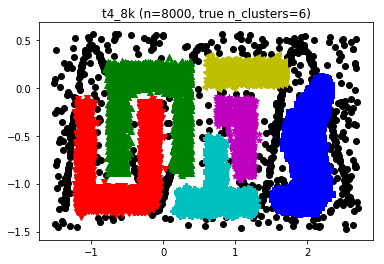

In [2]:
path = "benchmark_data"
dataset = "t4_8k"

# Load an example 2D dataset
X = np.loadtxt("%s/%s.data.gz" % (path,dataset), ndmin=2)

# Load the corresponding reference labels.
# The original labels are in {1,2,..,k} and 0 denotes the noise cluster.
# Let's make them more Python-ish by subtracting 1 (and hence the noise cluster will be marked as -1).
labels_true = np.loadtxt("%s/%s.labels0.gz" % (path,dataset), dtype='int')-1
n_clusters = len(np.unique(labels_true))-1 # do not count the "noise" cluster as a separate entity

# Center and scale (proportionally in all the axes) all the points.
# Note: this is NOT a standardization of all the variables.
X = (X-np.mean(X))/np.std(X, ddof=1)

# Plot the dataset
genieclust.plots.plot_scatter(X, labels_true)
plt.title("%s (n=%d, true n_clusters=%d)"%(dataset, X.shape[0], n_clusters))
plt.show()

The black dots mark the noise points.

Let's apply the Genie algorithm (with the default/recommended `gini_threshold` value):

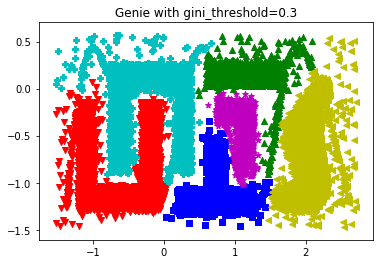

In [3]:
g = genieclust.genie.Genie(n_clusters=n_clusters)
labels_genie = g.fit_predict(X)
genieclust.plots.plot_scatter(X, labels_genie)
plt.title("Genie with gini_threshold=%g"%(g.gini_threshold))
plt.show()

We can compare the resulting clustering (ignoring the noise points now)
with the reference one by computing, for example, the confusion matrix.

In [4]:
# Compute the confusion matrix (with pivoting)
confusion_matrix = genieclust.compare_partitions.normalize_confusion_matrix(
    genieclust.compare_partitions.confusion_matrix(labels_true[labels_true>=0], labels_genie[labels_true>=0])
)
pd.DataFrame(confusion_matrix)

,0,1,2,3,4,5
0,1745,1,0,0,0,0
1,0,1669,0,0,0,0
2,0,0,1559,0,0,0
3,0,0,0,965,0,0
4,0,0,0,0,658,0
5,0,0,0,0,0,647


The above confusion matrix can be summarized using some cluster similarity measures, like the Adjusted Rand Index (`ar`).

In [5]:
# See also: sklearn.metrics.adjusted_rand_score()
genieclust.compare_partitions.compare_partitions(confusion_matrix)

{'ar': 0.9995794961339594,
 'r': 0.9998698642601135,
 'fm': 0.9996599614072649,
 'afm': 0.999579496169374}

The `ar` score of $\sim 1.0$ indicates an extremely fine match between the two partitions.
To recall, the maximum possible Rand score is 1.0. This would happen if the two partitions
were identical.

# A Comparison with k-means

For the sake of comparison, let's apply the k-means algorithm on the same dataset.

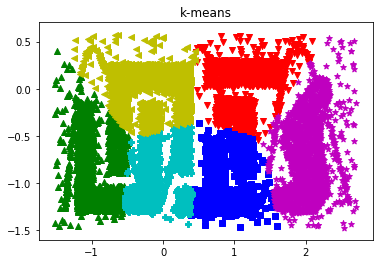

In [6]:
import sklearn.cluster
labels_kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters).fit_predict(X)
genieclust.plots.plot_scatter(X, labels_kmeans)
plt.title("k-means")
plt.show()

In [7]:
# Compute the confusion matrix for k-means
confusion_matrix_kmeans = genieclust.compare_partitions.normalize_confusion_matrix(
    genieclust.compare_partitions.confusion_matrix(labels_true[labels_true>=0], labels_kmeans[labels_true>=0].astype(np.int_))
)
pd.DataFrame(confusion_matrix_kmeans)

,0,1,2,3,4,5
0,889,213,0,0,0,644
1,301,1093,0,0,0,275
2,0,0,1551,8,0,0
3,0,0,0,843,0,122
4,0,0,0,268,390,0
5,0,0,0,0,647,0


In [8]:
# Cluster similarity measures for k-means
genieclust.compare_partitions.compare_partitions(confusion_matrix_kmeans)

{'ar': 0.6003523972583651,
 'r': 0.8815314971564159,
 'fm': 0.6735089392128826,
 'afm': 0.601606821549792}